<a href="https://colab.research.google.com/github/anaisabelveg/tfm/blob/main/Regresion_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En primer lugar, preparamos el entorno con las bibliotecas y datos necesarios:

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

Subimos nuestro dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving transit_limpio.csv to transit_limpio (1).csv


Creamos el dataframe a partir del archivo transit_limpio.csv

In [ ]:
dfTransit = pd.read_csv("transit_limpio.csv")
dfTransit.head(10)

,region,price,year,cylinders,fuel,odometer,title_status,transmission,drive,lat,long
0,birmingham,31900,2019.0,6,1,29497.0,1,1,1,36.464100,-86.658280
1,birmingham,32900,2019.0,6,1,6735.0,1,1,1,36.464100,-86.658280
2,birmingham,34500,2019.0,6,1,7646.0,1,1,1,36.464100,-86.658280
3,birmingham,32700,2019.0,6,1,13646.0,1,1,1,36.464100,-86.658280
4,birmingham,32900,2019.0,6,1,6735.0,1,1,1,36.464100,-86.658280
5,birmingham,34800,2019.0,6,1,31020.0,1,1,1,36.464100,-86.658280
6,birmingham,32800,2018.0,6,1,43479.0,1,1,1,36.464100,-86.658280
7,birmingham,38300,2020.0,6,1,7540.0,1,1,1,36.464100,-86.658280
8,birmingham,34800,2019.0,6,1,31020.0,1,1,1,36.464100,-86.658280
9,huntsville / decatur,14882,2015.0,6,1,151780.0,2,1,1,36.107596,-86.743824


Dividimos el dataset en 80% datos de entrenamiento y 20% datos de prueba (test)

In [ ]:
from sklearn.model_selection import train_test_split

# convertimos el DataFrame al formato necesario para scikit-learn
data = dfTransit.values 

y = data[:, 1:2]     # nos quedamos con la 2ª columna, price
y=y.astype('int')
X = data[:, 2:9]      # nos quedamos con el resto

feature_names = dfTransit.columns[2:9]

# Dividimos los datos en entrenamiento y test (80 training, 20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (287, 7)
Datos test:  (72, 7)



## 1.1. Árbol de decisión convencional

En primer lugar entrenamos un árbol de decisión convencional para hacernos una idea de las prestaciones que alcanzamos.

best mean cross-validation score: 0.713
best parameters: {'max_depth': 6}


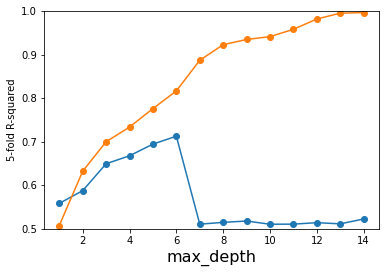

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# parámetros para GridSearch
max_depth = range(1, 15)
tuned_parameters = {'max_depth': max_depth}

max_depth_arr = range(1, 15)
n_folds = 5

clf = DecisionTreeRegressor(random_state=0)
grid = GridSearchCV(clf, param_grid=tuned_parameters, cv=n_folds, return_train_score=True) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(max_depth_arr, scores_test, '-o', label='Validación')
plt.plot(max_depth_arr, scores_train, '-o', label='Entrenamiento')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('{}-fold R-squared'.format(n_folds))
plt.ylim((0.5, 1))
plt.show()

In [ ]:
best_max_depth = grid.best_params_['max_depth']
tree_model = DecisionTreeClassifier(max_depth=best_max_depth)
tree_model.fit(X_train, y_train)

print("Train: ", tree_model.score(X_train, y_train))
print("Test: ", tree_model.score(X_test, y_test))

Train:  0.4912891986062718
Test:  0.3194444444444444


## 1.2. Random forest

En un *random forest* aparecen nuevos parámetros libres:
- Número de árboles construidos: aquí hemos de asegurarnos que la función de coste es estable para el número de árboles elegido.
- Número máximo de características a seleccionar aleatoriamente para ajustar cada árbol.

Además de los propios de los árboles de decisión:
- Complejidad de los mismos (normalmente `max_depth` o `min_samples_leaf`)

best mean cross-validation score: 0.749
best parameters: {'max_depth': 12}


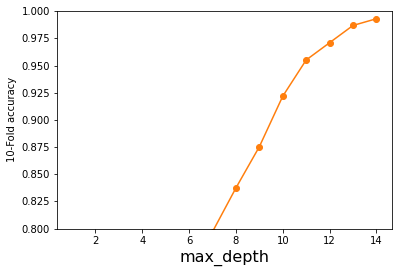

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# grid search
max_depth_arr = range(1, 15)
params = {'max_depth': max_depth_arr}
n_folds = 10

clf = RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt')
grid = GridSearchCV(clf, param_grid=params, cv=n_folds, return_train_score=True)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(max_depth_arr, scores_test, '-o', label='Validación')
plt.plot(max_depth_arr, scores_train, '-o', label='Entrenamiento')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('{}-Fold accuracy'.format(n_folds))
plt.ylim((0.8, 1))
plt.show()

In [ ]:
best_max_depth = grid.best_params_['max_depth']
bag_model = RandomForestClassifier(max_depth=best_max_depth, n_estimators=200, max_features='sqrt')
bag_model.fit(X_train, y_train)

print("Train: ", bag_model.score(X_train, y_train))
print("Test: ", bag_model.score(X_test, y_test))

Train:  0.9651567944250871
Test:  0.7083333333333334


## 1.3. Importancia de las variables

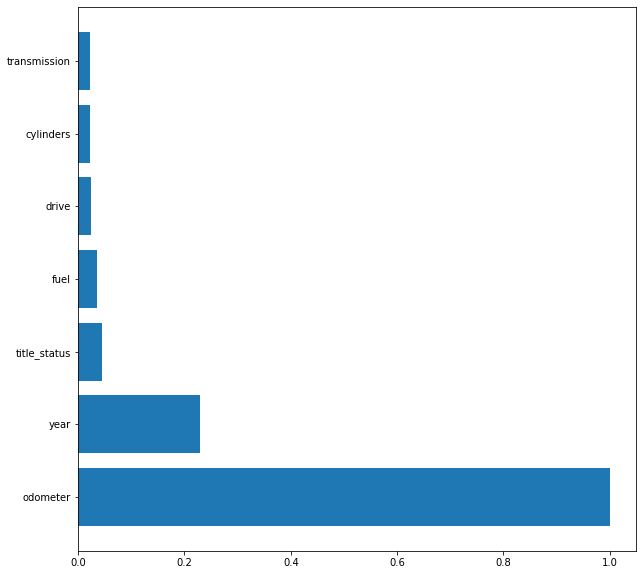

In [ ]:
importances = bag_model.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), feature_names[indices])
plt.show()

Utilizando este ranking, podemos hacer selección de características:

In [ ]:
from sklearn.model_selection import KFold

N, N_features = X_train.shape

rf = RandomForestClassifier(max_depth=best_max_depth, n_estimators=200, max_features='sqrt')
n_folds = 10
kf  = KFold(n_splits=n_folds, shuffle=True, random_state=1)
cv_error = []
cv_std = []

for nfeatures in range(N_features, 0, -1):
        
    error_i = []
    
    for idxTrain, idxVal in kf.split(X_train):
        
        Xt = X_train[idxTrain,:]
        yt = y_train[idxTrain]
        Xv = X_train[idxVal,:]
        yv = y_train[idxVal]
        
        rf.fit(Xt, yt)
        
        ranking = rf.feature_importances_
        indices = np.argsort(ranking)[::-1] 
    
        selected = indices[0:(N_features-nfeatures+1)]
        
        Xs = Xt[:, selected]
        
        rf.fit(Xs, yt)
        error = (1.0 - rf.score(Xv[:, selected], yv))     
        error_i.append(error) 
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))
    
    print('# features: ' + str(len(selected)) + ', error: ' + str(np.mean(error_i)) + ' +/- ' + str(np.std(error_i)))

# features: 1, error: 0.254064039408867 +/- 0.06286351732737748
# features: 2, error: 0.25061576354679804 +/- 0.05652494710285419
# features: 3, error: 0.25061576354679804 +/- 0.05652494710285419
# features: 4, error: 0.25061576354679804 +/- 0.05652494710285419
# features: 5, error: 0.25061576354679804 +/- 0.05652494710285419
# features: 6, error: 0.25061576354679804 +/- 0.05652494710285419
# features: 7, error: 0.25061576354679804 +/- 0.05652494710285419


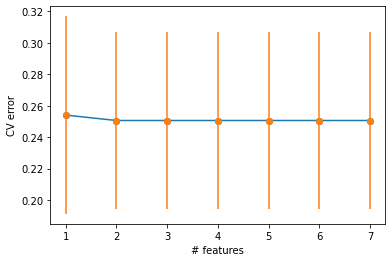

In [ ]:
plt.plot(range(1, N_features+1,1), cv_error, '-o')
plt.errorbar(range(1, N_features+1,1), cv_error, yerr=cv_std, fmt='o')
plt.xlabel('# features')
plt.ylabel('CV error')
plt.show()

## 2. Ejemplo en regresión

best mean cross-validation score: 0.737
best parameters: {'max_depth': 12}


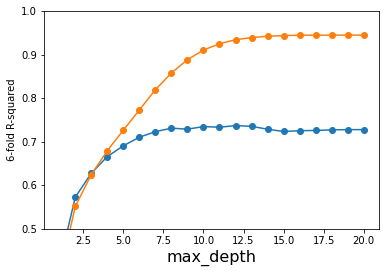

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# parámetros para GridSearch
max_depth_arr = range(1, 20+1)
tuned_parameters = {'max_depth': max_depth_arr}

n_folds = 6 # ponemos este valor algo bajo para que no tarde demasiado

clf = RandomForestRegressor(random_state=0, n_estimators=100, max_features='sqrt')
grid = GridSearchCV(clf, param_grid=tuned_parameters, cv=n_folds, return_train_score=True) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(max_depth_arr, scores_test, '-o', label='Validación')
plt.plot(max_depth_arr, scores_train, '-o', label='Entrenamiento')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('{}-fold R-squared'.format(n_folds))
plt.ylim((0.5, 1))
plt.show()

In [ ]:
best_max_depth = grid.best_params_['max_depth']
bag_model = RandomForestRegressor(max_depth=best_max_depth)
bag_model.fit(X_train, y_train)

print("Train: ", bag_model.score(X_train, y_train))
print("Test: ", bag_model.score(X_test, y_test))

Train:  0.942161397137524
Test:  0.8500255957291981


Visualizamos el arbol

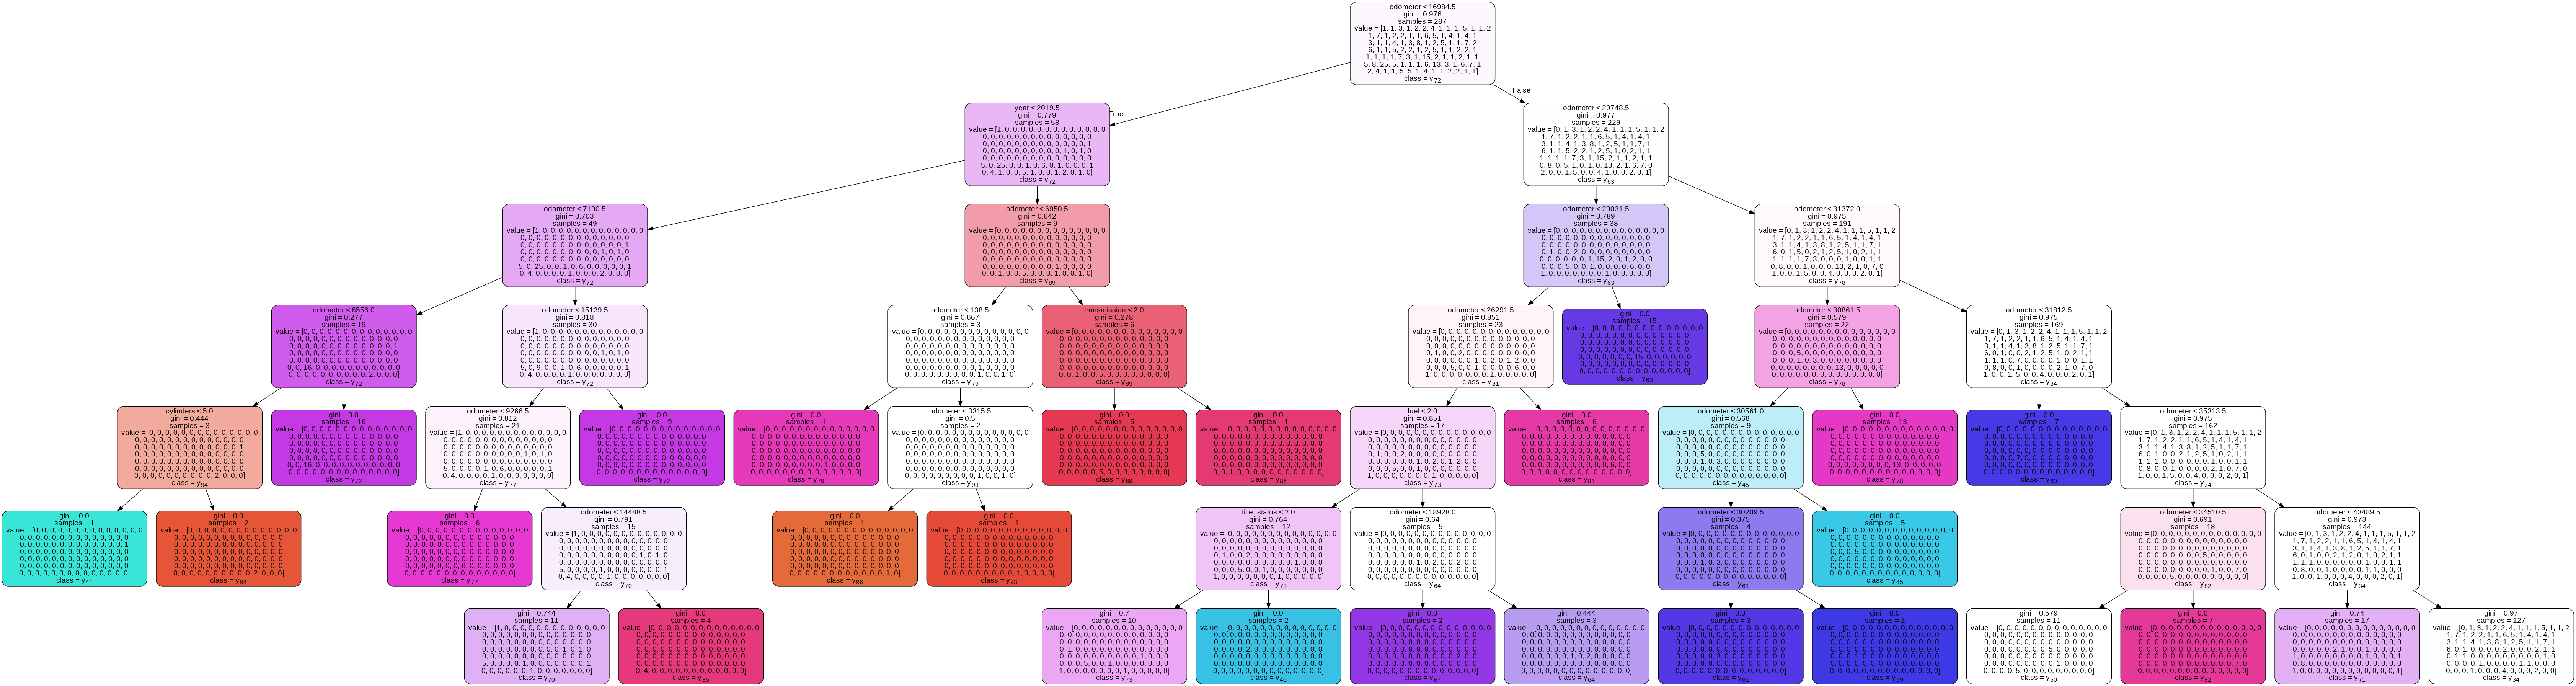

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import DecisionTreeClassifier

#decision_tree_classifier=DecisionTreeClassifier()
#class_names = decision_tree_classifier.classes_
tree_dot = export_graphviz(tree_model, out_file=None, feature_names=feature_names, class_names=True,  
                         filled=True, rounded=True,  special_characters=True)
graph = graphviz.Source(tree_dot)

# Mostrar grafo como SVG
# graph

# Mostrar grafo como PNG
from IPython.display import Image
Image(graph.pipe(format='png'))